In [1]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU (this may not be needed on your computer)

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


### load packages

In [3]:
from tfumap.umap import tfUMAP

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
import umap
import pandas as pd

### Load dataset

In [5]:
from tensorflow.keras.datasets import fashion_mnist

In [6]:
# load dataset
(train_images, Y_train), (test_images, Y_test) = fashion_mnist.load_data()
X_train = (train_images/255.).astype('float32')
X_test = (test_images/255.).astype('float32')
X_train = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))

# subset a validation set
n_valid = 10000
X_valid = X_train[-n_valid:]
Y_valid = Y_train[-n_valid:]
X_train = X_train[:-n_valid]
Y_train = Y_train[:-n_valid]

# flatten X
X_train_flat = X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:])))
X_test_flat = X_test.reshape((len(X_test), np.product(np.shape(X_test)[1:])))
X_valid_flat= X_valid.reshape((len(X_valid), np.product(np.shape(X_valid)[1:])))
print(len(X_train), len(X_valid), len(X_test))

50000 10000 10000


### define networks

In [7]:
dims = (28,28,1)
n_components = 64

In [8]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Create model and train

In [9]:
embedder = tfUMAP(
    direct_embedding=False,
    verbose=True,
    negative_sample_rate=5,
    training_epochs=5,
    encoder=encoder,
    dims = dims,
)

In [10]:
z = embedder.fit_transform(X_train_flat)

tfUMAP(dims=(28, 28, 1),
       encoder=<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe6c0a2e438>,
       negative_sample_rate=5,
       optimizer=<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fe6c0296978>,
       tensorboard_logdir='/tmp/tensorboard/20200714-103502',
       training_epochs=5)
Construct fuzzy simplicial set
Tue Jul 14 10:35:02 2020 Finding Nearest Neighbors
Tue Jul 14 10:35:02 2020 Building RP forest with 16 trees
Tue Jul 14 10:35:05 2020 parallel NN descent for 16 iterations
	 0  /  16
	 1  /  16
	 2  /  16
	 3  /  16
Tue Jul 14 10:35:16 2020 Finished Nearest Neighbor Search
Tue Jul 14 10:35:23 2020 Embedding with TensorFlow


Tue Jul 14 10:47:16 2020 Finished embedding


### Plot model output

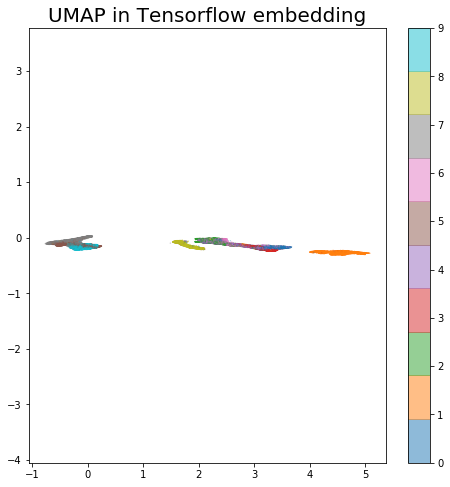

In [11]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

### View loss

In [12]:
from tfumap.umap import retrieve_tensors
import seaborn as sns

In [13]:
loss_df = retrieve_tensors(embedder.tensorboard_logdir)
loss_df[:3]

['umap_loss']
[]


,wall_time,step,val,group,variable
0,1.594748e+09,1,2.382998,train,umap_loss
1,1.594748e+09,2,1.492140,train,umap_loss
2,1.594748e+09,3,1.062982,train,umap_loss


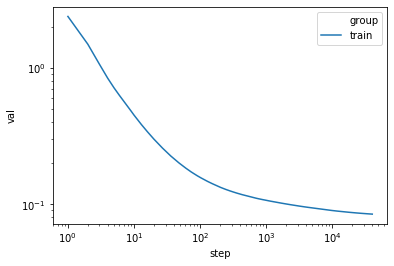

In [14]:
ax = sns.lineplot(x="step", y="val", hue="group", data=loss_df[loss_df.variable=='umap_loss'])
ax.set_xscale('log')
ax.set_yscale('log')

### Save output

In [15]:
from tfumap.paths import ensure_dir, MODEL_DIR

In [16]:
output_dir = MODEL_DIR/'projections'/ 'fmnist' / '64'/ 'network'
ensure_dir(output_dir)

In [17]:
embedder.save(output_dir)

Pickle of model saved


W0714 10:47:39.749605 140632044066624 deprecation.py:506] From /mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
I0714 10:47:39.885303 140632044066624 builder_impl.py:775] Assets written to: /mnt/cube/tsainbur/Projects/github_repos/umap_tf_networks/models/projections/fmnist/64/network/encoder/assets


Encoder Keras model saved


In [18]:
loss_df.to_pickle(output_dir / 'loss_df.pickle')

In [19]:
np.save(output_dir / 'z.npy', z)